In [2]:
import pandas as pd
import numpy as np

In [3]:
def format_stars(stars):
    stars = stars.split(', \'')
    stars = [star for star in stars if star != '' and star != '    Stars:\'']
    stars[0] = stars[0][2:]
    stars[-1] = stars[-1][:-2]

    dir_index = -1
    for j in range(len(stars)):
        stars[j] = stars[j].replace(', "', '')
        if 'Stars:\'' in stars[j]:
            stars[j] = stars[j].split(':\'')[1]
        
        if '|' in stars[j]:
            dir_index = j
    
    stars = stars[dir_index + 1:]

    return stars if stars != [] else None

def format_genres(genre):
    genres = genre.split(', ')
    return genres[0] if genres != [] else None

def format_years(year):
    if len(year) < 5 or year[1] not in ['1', '2']:
        return None
    return int(year[1:5])

def set_is_tv(duration):
    duration = int(duration[0: -4])

    if duration < 75:
        return True
    return False

def get_cleaned_dataframe():
    df = pd.read_csv('./n_movies.csv')
    df = df.drop(columns=['description', 'votes', 'certificate'])
    df = df.dropna(subset=['stars', 'duration', 'year', 'genre'])
    df = df.drop_duplicates(subset=['title'])

    df['stars'] = df['stars'].apply(format_stars)
    df['genre'] = df['genre'].apply(format_genres)
    df['year'] = df['year'].apply(format_years)
    df['is_tv'] = df['duration'].apply(set_is_tv)

    df = df.dropna()
    df = df.reset_index()
    
    return df


In [39]:
df = get_cleaned_dataframe()

In [5]:
conda install pyvis

error: incomplete escape \U at position 28

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyvis.network import Network

# Network Visualization of Movies with shared actors

def create_network(df, network, num_nodes):
    
    for i in tqdm(range(num_nodes)):
        network.add_node(df.loc[i,'title'], value=network)
    
    for i in tqdm(range(num_nodes)):
        for j in range(i + 1, num_nodes):
            w = 0
            for actor in df.loc[i, 'stars']:
                if actor in df.loc[j, 'stars']:
                    w += 5
            if w > 0:
                network.add_weighted_edges_from(df.loc[i, 'title'], df.loc[j, 'title'], w='weight')
    return network

movie_network = nx.Graph()
tv_show_network = nx.MultiGraph()
combine_network = nx.MultiGraph()

media = df.dropna().reset_index(drop=True)
movies = df.where(df['is_tv'] == False).dropna().reset_index(drop=True)
tv_shows = df.where(df['is_tv'] == True).dropna().reset_index(drop=True)

# Movie Network
scale=3
movie_network = create_network(movies, nt_movie, 500)
tv_show_network = create_network(tv_shows, nt_tv_show, 500)
combine_network = create_network(media, nt_combine, 500)

d_movie = dict(movie_network.degree)
d_movie.update((x, scale*y) for x, y in d_movie.items())
d_tv_show = dict(tv_show_network.degree)
d_tv_show.update((x, scale*y) for x, y in d_tv_show.items())
d_combine = dict(combine_network.degree)
d_combine.update((x, scale*y) for x, y in d_combine.items())

#Setting up size attribute
nx.set_node_attributes(movie_network,d_movie,'size')
nx.set_node_attributes(tv_show_network,d_tv_show,'size')
nx.set_node_attributes(combine_network,d_combine,'size')

nt_movie = Network("500px", "500px")
nt_tv_show = Network("800px", "800px")
nt_combine = Network("800px", "800px")

nt_movie.from_nx(movie_network)
nt_movie.show_buttons()
nt_tv_show.from_nx(tv_show_network)
nt_combine.from_nx(combine_network)

nt_movie.show("nx_movie.html")
nt_tv_show.show("nx_tv_show.html")
nt_combine.show("nx_combine.html")

NameError: name 'nt_movie' is not defined

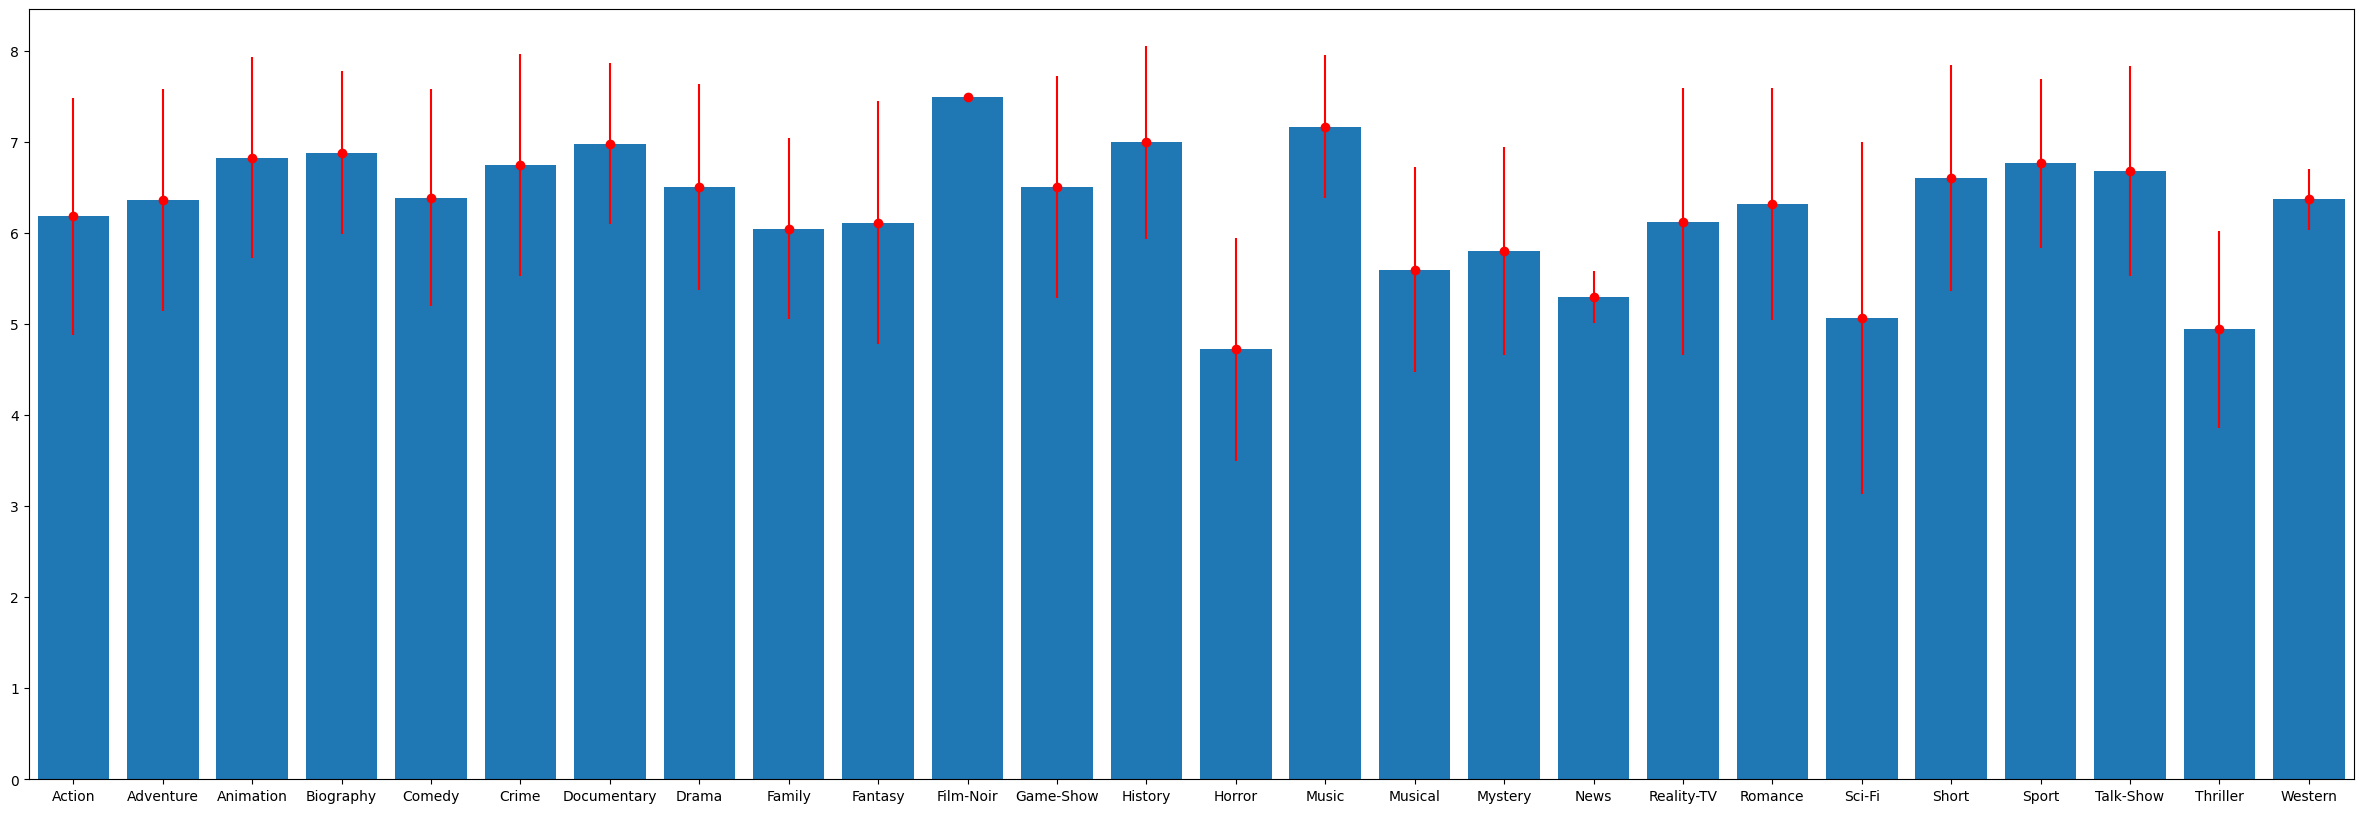

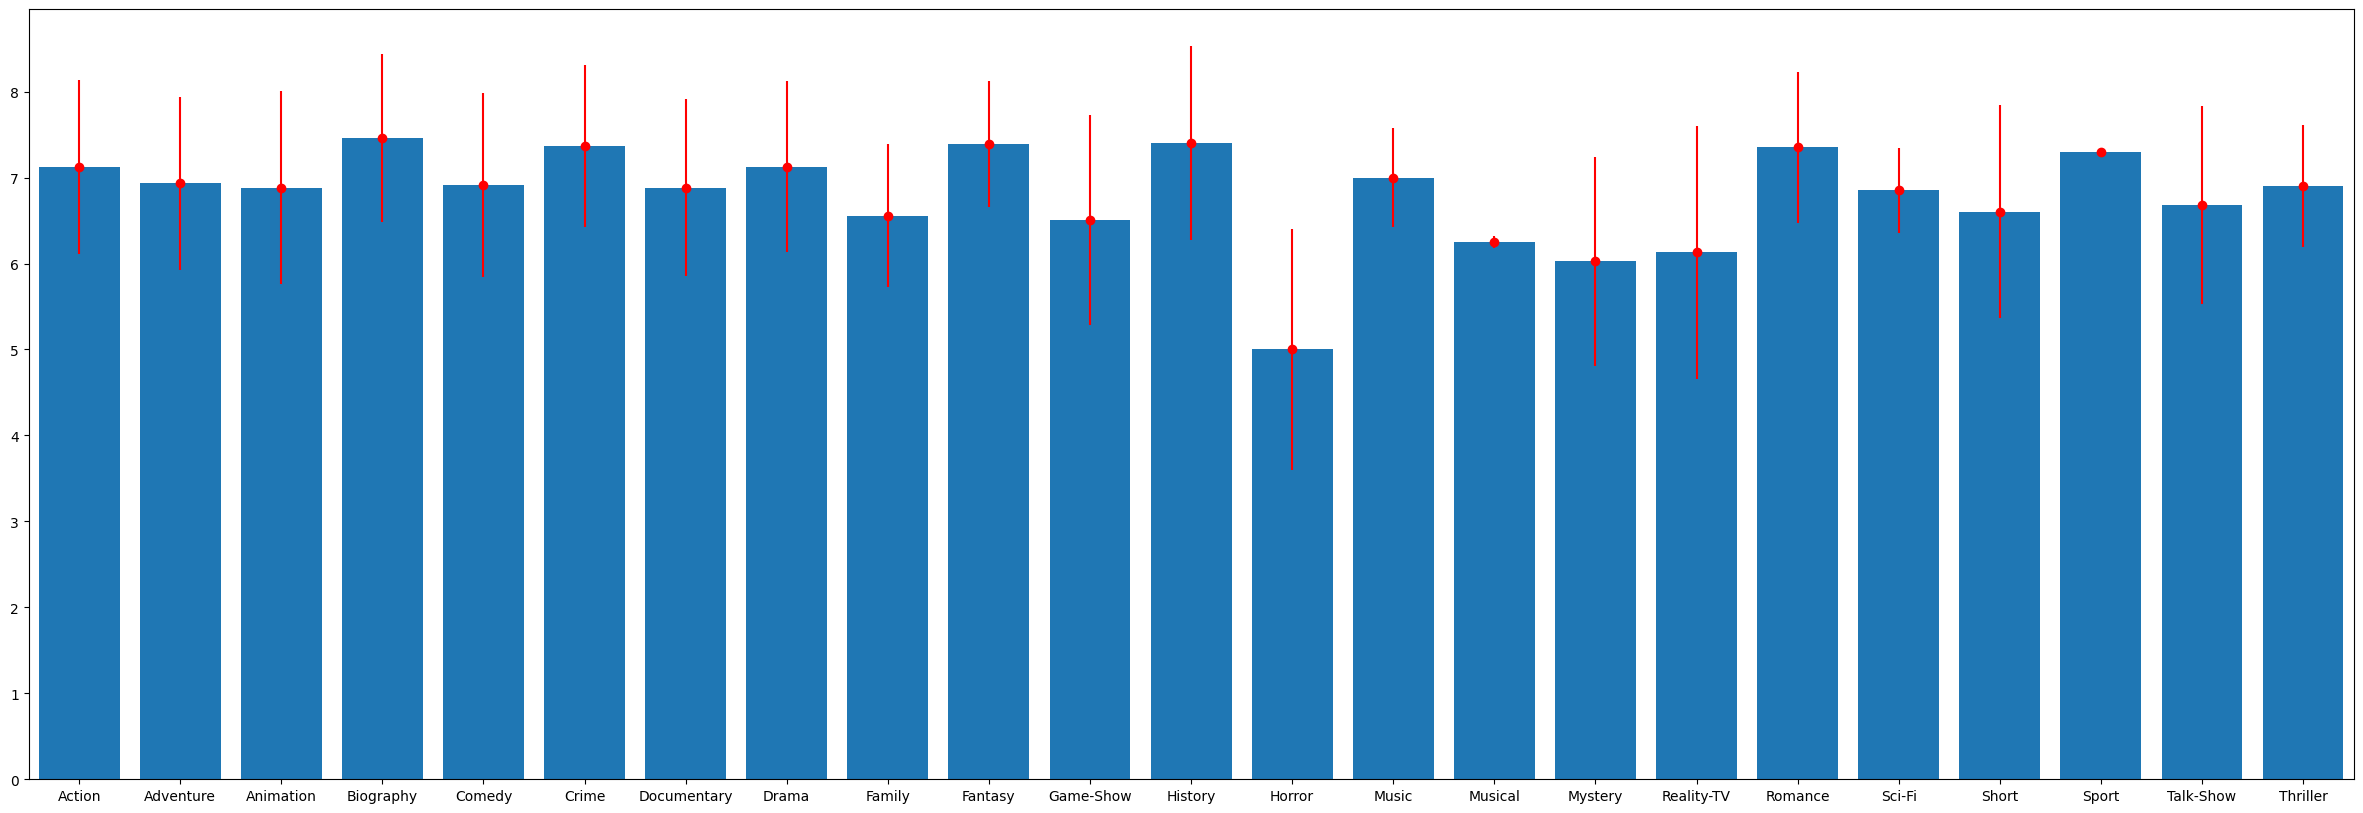

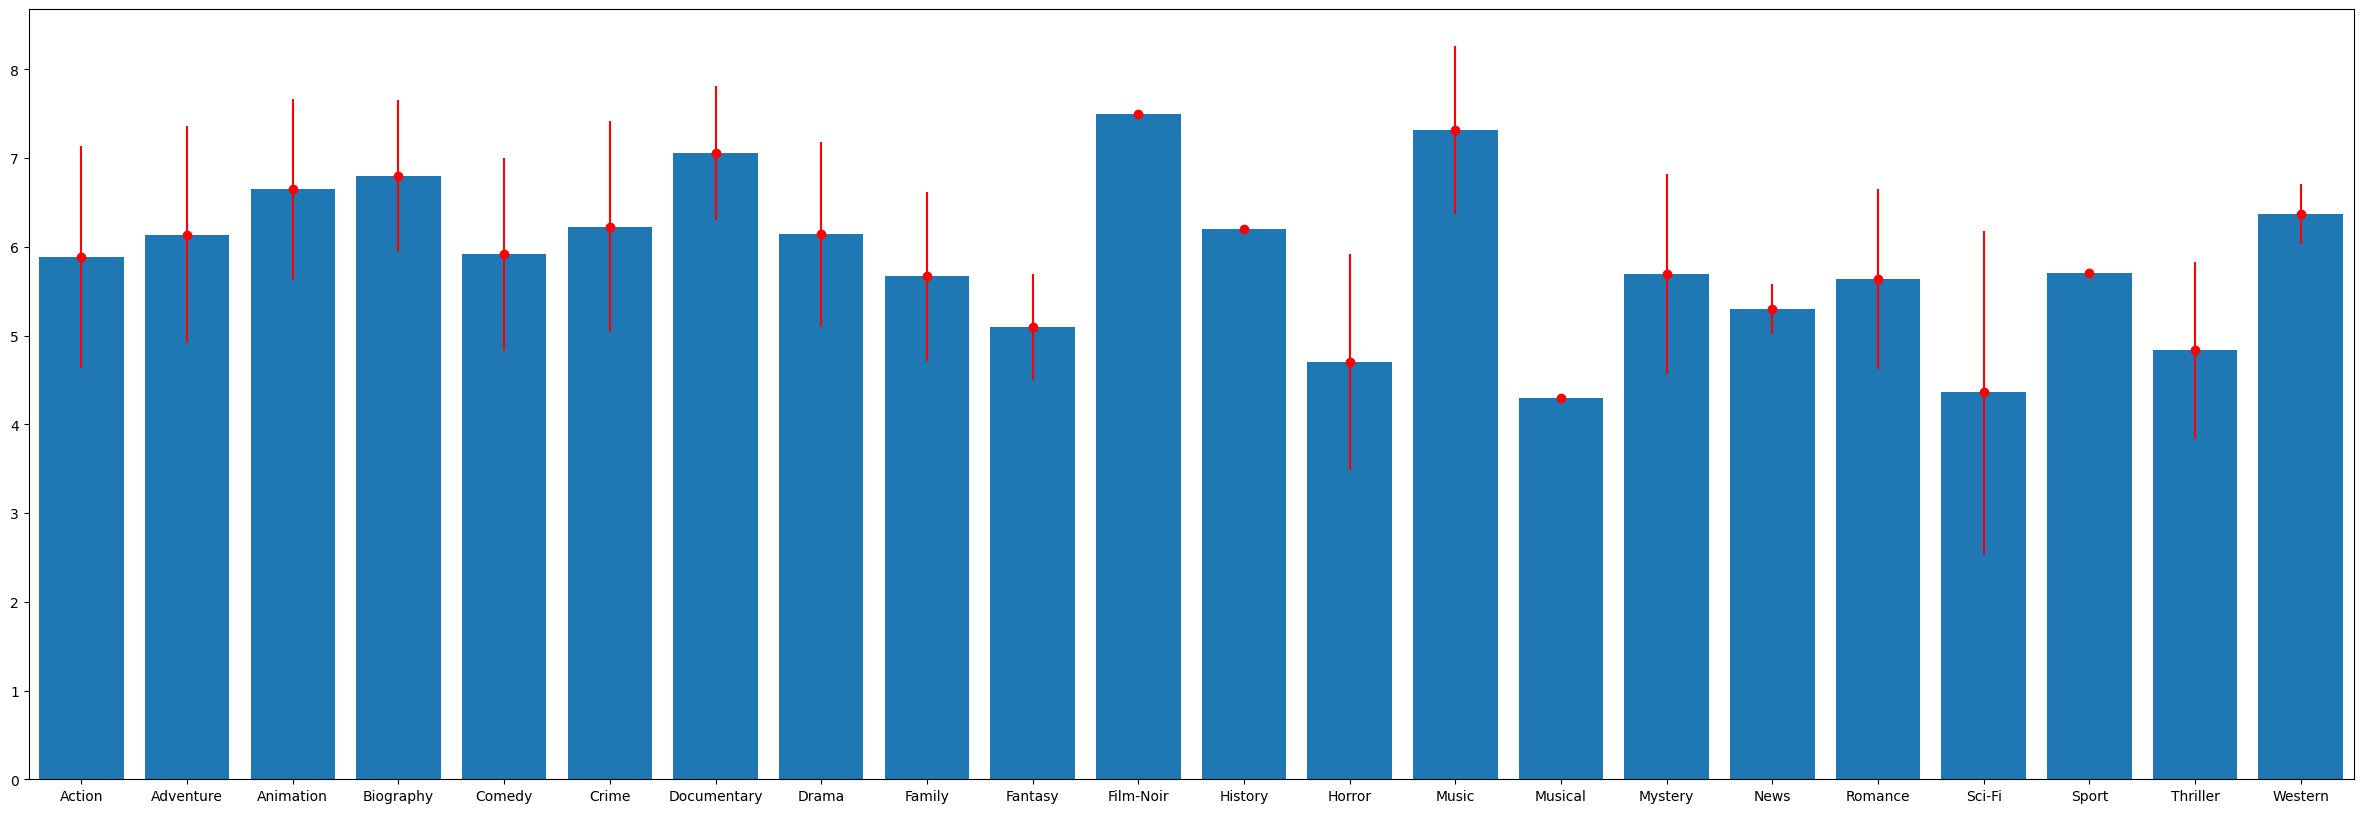

In [44]:

def plot_genre_v_rating(df):
    grouped_df = df.groupby('genre')

    labels = grouped_df.groups.keys()
    means = grouped_df['rating'].mean().tolist()
    stds = grouped_df['rating'].std().tolist()

    plt.figure(figsize=(30, 10))
    plt.bar(x=labels, height=means)
    plt.errorbar(range(len(labels)), means, yerr=stds, fmt="or")
    plt.xlim(-0.5,len(labels)-.5)

    plt.show()

plot_genre_v_rating(df)
plot_genre_v_rating(df.where(df['is_tv'] == True))
plot_genre_v_rating(df.where(df['is_tv'] == False))